https://github-com.translate.goog/Gurobi/modeling-examples/tree/master/price_optimization?_x_tr_sl=en&_x_tr_tl=ja&_x_tr_hl=ja&_x_tr_pto=sc
https://gurobi--machinelearning-readthedocs-io.translate.goog/en/stable/mlm-examples/price_optimization.html?_x_tr_sl=en&_x_tr_tl=ja&_x_tr_hl=ja&_x_tr_pto=sc

###ここではScikit-learn、回帰モデルと Gurobi Machine Learning を使用して Gurobi モデルに回帰を埋め込むことを狙っている
###適切なアボカド価格を設定するには微妙なトレードオフが必要です。高く設定しすぎると、顧客を失います。安すぎると利益が出ません。
###優れたデータがあれば、アボカドの価格設定と供給の問題は、最適化とデータ サイエンスの力を実証する機会に満ちています
## 目標: アボカドの価格設定と流通のため、収益を最大化します。

In [1]:
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np

In [2]:
import sys
!python --version

Python 3.9.6


###HAB のデータセットには、2019 年から 2022 年の売上データが含まれています。このデータは、2015 年から 2018 年の売上高でKaggleで入手可能な
###HAB からの以前のダウンロードによって補強されます。
###データセットの各行は、週ごとのアボカド販売数と、地域およびアボカドの種類別に分類されたアボカドの週平均価格です。
###アボカドには、従来型とオーガニックの 2 種類があります。このノートでは、従来のアボカドのみを検討します。
###五大湖、ミッドサウス、ノースイースト、ニューイングランド北部、サウスセントラル、サウスイースト、ウェスト、プレーンズの 8 つの大きな地域があります。



In [2]:
data_url = "https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/"
avocado = pd.read_csv(
    data_url + "HABdata_2019_2022.csv"
)  # dataset downloaded directly from HAB
avocado_old = pd.read_csv(
    data_url + "kaggledata_till2018.csv"
)  # dataset downloaded from Kaggle
avocado = pd.concat([avocado, avocado_old])
avocado



,region,date,type,price,units_sold
0,Great_Lakes,1/7/19 0:00,Conventional,1.106743,3812441.96
1,Great_Lakes,1/7/19 0:00,Organic,1.371280,275987.52
2,Great_Lakes,1/13/19 0:00,Conventional,1.063457,3843318.68
3,Great_Lakes,1/13/19 0:00,Organic,1.493384,244991.95
4,Great_Lakes,1/20/19 0:00,Conventional,1.049931,4587957.69
...,...,...,...,...,...
3703,West,11/18/18,Organic,1.610000,334096.14
3704,West,11/25/18,Conventional,1.240000,3260102.17
3705,West,11/25/18,Organic,1.730000,268362.34
3706,West,12/2/18,Conventional,1.200000,4594863.86


## データセットを準備する
###次に、売上予測を行うためのデータを準備します。年と季節の新しい列をデータフレームに追加します。2015 年から 2022 年までの各年に、
###年の昇順で 0 から 7 までのインデックスを与えるとします。ピーク シーズンを 2 月から 7 月までと定義します。
###これらの月は傾向の目視検査に基づいて設定されますが、他の月を設定することもできます。

In [3]:
# Add the index for each year from 2015 through 2022
avocado["date"] = pd.to_datetime(avocado["date"])
avocado["year"] = pd.DatetimeIndex(avocado["date"]).year
avocado = avocado.sort_values(by="date")

# Define the peak season
avocado["month"] = pd.DatetimeIndex(avocado["date"]).month
peak_months = range(2, 8)  # <--------- Set the months for the "peak season"


def peak_season(row):
    return 1 if int(row["month"]) in peak_months else 0


avocado["peak"] = avocado.apply(lambda row: peak_season(row), axis=1)

# Scale the number of avocados to millions
avocado["units_sold"] = avocado["units_sold"] / 1000000

# Select only conventional avocados
avocado = avocado[avocado["type"] == "Conventional"]

avocado = avocado[
    ["date", "units_sold", "price", "region", "year", "month", "peak"]
].reset_index(drop=True)

avocado


,date,units_sold,price,region,year,month,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0
...,...,...,...,...,...,...,...
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,1
3400,2022-05-15,3.542902,1.514583,Midsouth,2022,5,1


## パート 1: データの傾向を観察する
ここで、時間と季節の売上傾向を推測します。簡単にするために、米国全体のデータを使用してみましょう。

In [4]:
df_Total_US = avocado[avocado["region"] == "Total_US"]


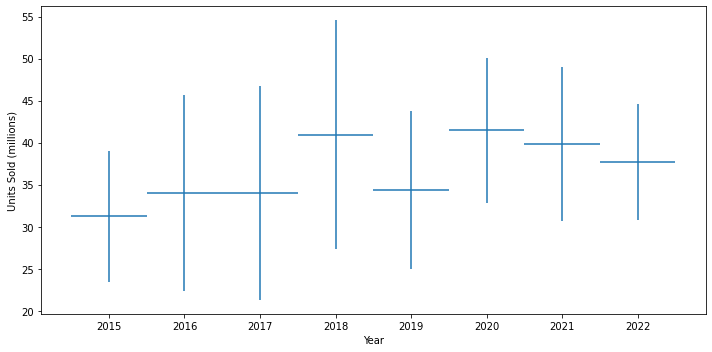

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

mean = df_Total_US.groupby("year")["units_sold"].mean()
std = df_Total_US.groupby("year")["units_sold"].std()
axes.errorbar(mean.index, mean, xerr=0.5, yerr=2 * std, linestyle="")
axes.set_ylabel("Units Sold (millions)")
axes.set_xlabel("Year")

fig.tight_layout()


#### 売上高は、わずかではありますが、一般的に年々増加していることがわかります。2019 年の落ち込みは、十分に文書化された2019 年のアボカド不足の影響で、アボカドの価格がほぼ 2 倍になりました。

## 季節性
#### ここで1年以内の販売動向を確認します

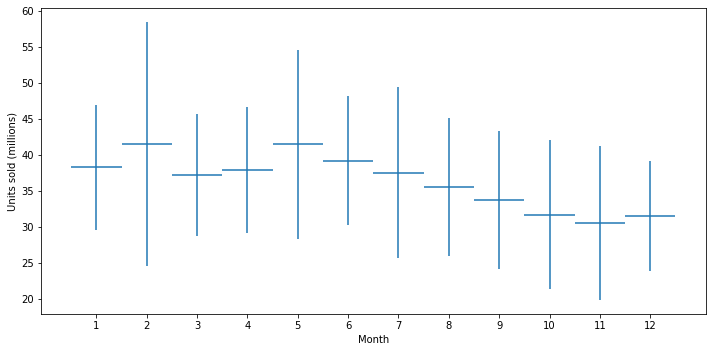

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

mean = df_Total_US.groupby("month")["units_sold"].mean()
std = df_Total_US.groupby("month")["units_sold"].std()

axes.errorbar(mean.index, mean, xerr=0.5, yerr=2 * std, linestyle="")
axes.set_ylabel("Units Sold (millions)")
axes.set_xlabel("Month")

fig.tight_layout()

plt.xlabel("Month")
axes.set_xticks(range(1, 13))
plt.ylabel("Units sold (millions)")
plt.show()


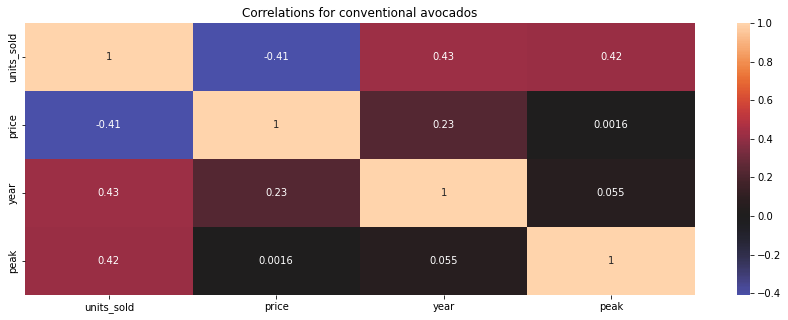

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.heatmap(
    df_Total_US[["units_sold", "price", "year", "peak"]].corr(),
    annot=True,
    center=0,
    ax=axes,
)

axes.set_title("Correlations for conventional avocados")
plt.show()


#### 販売数量はアボカドあたりの価格と負の相関があります。販売数量は、年とシーズンが繁忙期であることに正の相関があります。



## 地域
最後に、地域によって売上がどのように異なるかを見ていきます。これにより、各地域に供給したいアボカドの数が決まります。


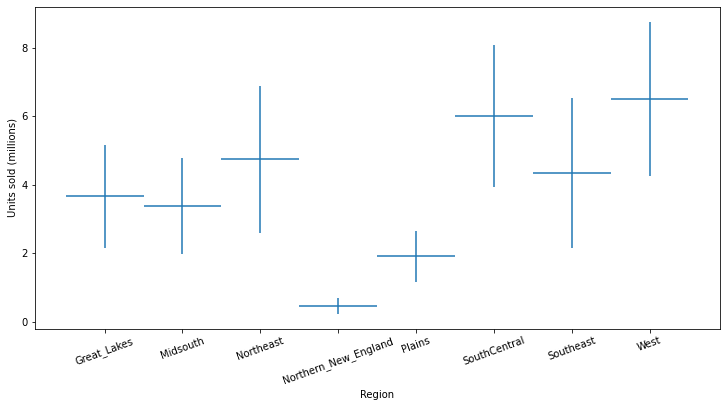

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

regions = [
    "Great_Lakes",
    "Midsouth",
    "Northeast",
    "Northern_New_England",
    "SouthCentral",
    "Southeast",
    "West",
    "Plains",
]
df = avocado[avocado.region.isin(regions)]

mean = df.groupby("region")["units_sold"].mean()
std = df.groupby("region")["units_sold"].std()

axes.errorbar(range(len(mean)), mean, xerr=0.5, yerr=2 * std, linestyle="")

fig.tight_layout()

plt.xlabel("Region")
plt.xticks(range(len(mean)), pd.DataFrame(mean)["units_sold"].index, rotation=20)
plt.ylabel("Units sold (millions)")
plt.show()


明らかに、西海岸の人はアボカドが大好きです。
## パート II: 売上を予測する

#### パート I で観察された傾向は、独立変数 (価格、年、地域、および季節性) を使用して販売の予測モデルを構築する動機となります。以降、販売数量を予測需要と呼びます。
#### 回帰モデルを検証するために、データセットをランダムに分割します。トレーニングとデータをテストしScikit-learnを使用して重みを学習します



In [9]:
from sklearn.model_selection import train_test_split

X = df[["region", "price", "year", "peak"]]
y = df["units_sold"]
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

feat_transform = make_column_transformer(
    (OneHotEncoder(drop="first"), ["region"]),
    (StandardScaler(), ["price", "year"]),
    ("passthrough", ["peak"]),
    verbose_feature_names_out=False,
    remainder='drop'
)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

lin_reg = make_pipeline(feat_transform, LinearRegression())
lin_reg.fit(X_train, y_train)

# Get R^2 from test data
y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")


The R^2 value in the test set is 0.8982069358257863


In [12]:
lin_reg.fit(X, y)

y_pred_full = lin_reg.predict(X)
print(f"The R^2 value in the full dataset is {r2_score(y, y_pred_full)}")


The R^2 value in the full dataset is 0.9066729322212483


パート III: アボカドの価格と供給を最適化する
アボカドの価格が需要にどのように影響するかがわかった場合、アボカドの最適な価格を設定するにはどうすればよいでしょうか? 価格を高く設定しすぎると、需要と売上が減少する可能性があるため、設定したくありません。同時に、価格を低く設定しすぎると、収益を最大化する際に最適ではない可能性があります. では、スイートスポットとは何ですか？

流通ロジスティクスでは、地域全体で十分な量のアボカドがあることを確認したいと考えています。これらの考慮事項は、数学的最適化モデルで対処できます。最適化モデルは、解が一連の制約を満たすように、目的関数に従って最適な解を見つけます。ここで、解は決定変数と呼ばれる実数値または整数値のベクトルとして表されます。制約は、決定変数の関数として記述された一連の方程式または不等式です。

毎週の初めに、利用可能な製品の総数が有限であると想定します。純収益を最大化しながら、この数量をさまざまな地域に分配する必要があります。つまり、各地域のアボカドの価格と、各地域に割り当てられるアボカドの数です。

モデルの作成に使用されるいくつかの入力パラメータと表記法を定義しましょう。下付き文字
は、各地域を表すために使用されます。

入力パラメータ

R:領域のセット、

d(p,r): 地域の予測需要  <mi>r</mi>
  <mo>∈</mo>
  <mi>R</mi>
製品あたりのアボカドがp
、

B: 地域全体に配布される利用可能なアボカド、

c_{waste}： 費用 （) 廃棄されたアボカドあたり、

c^r_{transport}： 費用 （）アボカドを地域に輸送するr \in R
、

: 最低価格と最高価格 (
) れいごんのアボカドあたり
、

: 地域に割り当てられるアボカドの最小数と最大数
、

次のコードは、Gurobi python パッケージをロードし、最適化モデルを開始します。の値
に設定されています
100 万個のアボカド。これは、データからの週あたりの平均供給値に近い値です。例として、2021 年のピーク シーズンを考えてみましょう。アボカドを無駄にするコストは、
. アボカドの輸送コストは
に
アボカドの供給の大部分が行われる南部の国境からの各地域の距離に基づいています。さらに、アボカドの価格を超えないように設定できます
各個に。



In [13]:
# Sets and parameters
B = 30  # total amount ot avocado supply

peak_or_not = 1  # 1 if it is the peak season; 1 if isn't
year = 2022

c_waste = 0.1  # the cost ($) of wasting an avocado

# the cost of transporting an avocado
c_transport = pd.Series(
    {
        "Great_Lakes": 0.3,
        "Midsouth": 0.1,
        "Northeast": 0.4,
        "Northern_New_England": 0.5,
        "SouthCentral": 0.3,
        "Southeast": 0.2,
        "West": 0.2,
        "Plains": 0.2,
    }, name='transport_cost'
)

c_transport = c_transport.loc[regions]
# the cost of transporting an avocado

# Get the lower and upper bounds from the dataset for the price and the number of products to be stocked
a_min = 0  # minimum avocado price in each region
a_max = 2  # maximum avocado price in each region

data = pd.concat([c_transport,
                  df.groupby("region")["units_sold"].min().rename('min_delivery'),
                  df.groupby("region")["units_sold"].max().rename('max_delivery')], axis=1)

In [14]:
data

,transport_cost,min_delivery,max_delivery
Great_Lakes,0.3,2.063574,7.094765
Midsouth,0.1,1.845443,6.168572
Northeast,0.4,2.364424,8.836406
Northern_New_England,0.5,0.219690,0.917984
SouthCentral,0.3,3.687130,10.323175
Southeast,0.2,2.197764,7.810475
West,0.2,3.260102,11.274749
Plains,0.2,1.058938,3.575499


pandas データを使用して gurobipy モデルをより簡単に作成するのに役立つ gurobipy-pandas を使用します。

まず、最適化問題で修正された機能を含むデータフレームを作成します。これは地域によって索引付けされ (各地域の需要を予測するために 1 つの回帰を使用したい)、固定機能に対応する 3 つの列があります。

・year
・peakの値でpeak_or_not
・region地域の名前を繰り返します。

データフレームを表示して、正しいことを確認します

In [ ]:
import gurobipy
import gurobipy_pandas as gppd
feats = pd.DataFrame(
    data={
        "year": year,
        "peak": peak_or_not,
        "region": regions,
    },
    index=regions
)
feats


In [16]:
import gurobipy as gp

m = gp.Model("Avocado_Price_Allocation")

p = gppd.add_vars(m, data, name="price", lb=a_min, ub=a_max)
x = gppd.add_vars(m, data, name="x", lb='min_delivery', ub='max_delivery')
s = gppd.add_vars(m, data, name="s") # predicted amount of sales in each region for the given price).
w = gppd.add_vars(m, data, name="w") # excess wasteage in each region).
d = gppd.add_vars(m, data, lb=-gp.GRB.INFINITY, name="demand") # Add variables for the regression

m.update()

# Display one of the variables
p


Great_Lakes                      <gurobi.Var price[Great_Lakes]>
Midsouth                            <gurobi.Var price[Midsouth]>
Northeast                          <gurobi.Var price[Northeast]>
Northern_New_England    <gurobi.Var price[Northern_New_England]>
SouthCentral                    <gurobi.Var price[SouthCentral]>
Southeast                          <gurobi.Var price[Southeast]>
West                                    <gurobi.Var price[West]>
Plains                                <gurobi.Var price[Plains]>
Name: price, dtype: object

In [17]:
m.setObjective((p * s).sum() - c_waste * w.sum() - (c_transport * x).sum(),
               gp.GRB.MAXIMIZE)

In [18]:
m.addConstr(x.sum() == B)
m.update()

In [19]:
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, x)
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, d)
m.update()

In [20]:
gppd.add_constrs(m, w, gp.GRB.EQUAL, x - s)
m.update()

In [21]:
feats = pd.concat([feats, p], axis=1)[["region", "price", "year", "peak"]]


feats

,region,price,year,peak
Great_Lakes,Great_Lakes,<gurobi.Var price[Great_Lakes]>,2022,1
Midsouth,Midsouth,<gurobi.Var price[Midsouth]>,2022,1
Northeast,Northeast,<gurobi.Var price[Northeast]>,2022,1
Northern_New_England,Northern_New_England,<gurobi.Var price[Northern_New_England]>,2022,1
SouthCentral,SouthCentral,<gurobi.Var price[SouthCentral]>,2022,1
Southeast,Southeast,<gurobi.Var price[Southeast]>,2022,1
West,West,<gurobi.Var price[West]>,2022,1
Plains,Plains,<gurobi.Var price[Plains]>,2022,1


In [22]:
# from gurobi_ml import add_predictor_constr
from gurobi_ml import add_predictor_constr
pred_constr = add_predictor_constr(m, lin_reg, feats, d)

pred_constr.print_stats()


Model for pipe1:
88 variables
24 constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans1           (8, 10)           24           16            0            0

lin_reg1              (8, 1)           64            8            0            0

--------------------------------------------------------------------------------


In [23]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Xeon(R) W-10885M CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 128 columns and 184 nonzeros
Model fingerprint: 0x37c19207
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 2e+03]
  RHS range        [1e+00, 2e+03]
Presolve removed 24 rows and 96 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 32 rows and 104 columns
Presolve time: 0.01s
Presolved: 34 rows, 33 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 33 continuous, 0 integer (0 binary)

Root relaxation: objective 5.288486e+01, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |  

In [24]:
solution = pd.DataFrame(index=regions)

solution["Price"] = p.gppd.X
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = w.gppd.X
solution["Pred_demand"] = d.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(4)




 The optimal net revenue: $42.508291 million


,Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,1.6639,3.4464,3.4464,0.0000,3.4464
Midsouth,1.5088,5.2723,3.5454,1.7268,3.5454
Northeast,2.0000,4.1387,4.1387,0.0000,4.1387
Northern_New_England,1.4412,0.9180,0.9180,0.0000,0.9180
SouthCentral,2.0000,4.4195,4.4195,0.0000,4.4195
Southeast,1.7464,3.8486,3.8486,0.0000,3.8486
West,2.0000,5.3075,5.3075,0.0000,5.3075
Plains,1.2021,2.6491,2.6491,0.0000,2.6491


In [25]:
print(
    "Maximum error in approximating the regression {:.6}".format(
        np.max(pred_constr.get_error())
    )
)


Maximum error in approximating the regression 2.66454e-15


In [26]:
pred_constr.input_values.drop('region', axis=1)

,price,year,peak
Great_Lakes,1.663872,2022,1
Midsouth,1.508809,2022,1
Northeast,2.0,2022,1
Northern_New_England,1.441157,2022,1
SouthCentral,2.0,2022,1
Southeast,1.74637,2022,1
West,2.0,2022,1
Plains,1.20207,2022,1


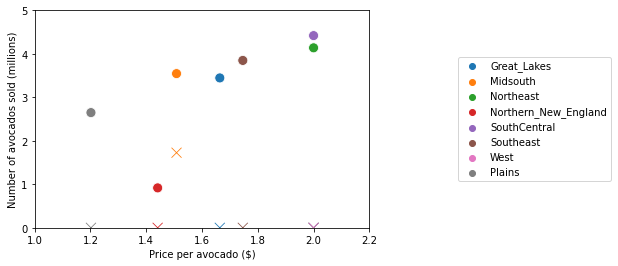

The circles represent sales quantity and the cross markers represent the wasted quantity.


In [27]:
fig, ax = plt.subplots(1, 1)

plot_sol = sns.scatterplot(data=solution, x="Price", y="Sold", hue=solution.index, s=100)
plot_waste = sns.scatterplot(
    data=solution, x="Price", y="Wasted", marker="x", hue=solution.index, s=100, legend=False
)

plot_sol.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1)
plot_waste.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0, 5)
plt.xlim(1, 2.2)
ax.set_xlabel("Price per avocado ($)")
ax.set_ylabel("Number of avocados sold (millions)")
plt.show()
print(
    "The circles represent sales quantity and the cross markers represent the wasted quantity."
)